#### IMPORT LIBRARIES

In [1]:
import numpy as np
import h5py as h5

import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable


import matplotlib.pyplot as plt
from importlib import reload, import_module

import glob
import os

import pdb
from PIL import Image as im
import _pickle as pickle
import cv2

from functions import processLF, get_variable, get_numpy, psnr_1

#### DATASET PATH

In [2]:
if os.name == 'nt':
    dataset_file = r"C:\Users\mummu\Documents\Datasets\srinivasan\trainset\h5\8bit.h5"
    test_file    = r"C:\Users\mummu\Documents\Datasets\srinivasan\testset\h5\8bit.h5"
    model_file   = r"model\model.pt"
    network_file = r"network"
    img_dir      = r"C:\Users\mummu\Documents\Datasets\kalantari\testset\EXTRA"
    img_paper    = r"C:\Users\mummu\Documents\Datasets\kalantari\testset\PAPER"
    
elif os.name == 'posix':
    raise NotImplementedError

#### BASIC PARAMETERS

In [3]:
minibatch_size = 1
gamma_val      = 0.4
lfsize         = [372, 540, 7, 7]
batch_affine   = True

In [4]:
trans = transforms.ToTensor()
p = np.ndarray([1])
q = np.ndarray([1])

In [5]:
network_module = import_module(network_file)
reload(network_module)

Net = network_module.Net

net = Net((lfsize[0], lfsize[1]), minibatch_size, lfsize, batchAffine=batch_affine)
net.eval()

if torch.cuda.is_available():
    print('##converting network to cuda-enabled')
    net.cuda()

try:
    checkpoint = torch.load(model_file)
    
    net.load_state_dict(checkpoint['model'].state_dict())    
    print('Model successfully loaded.')
    
except:
    print('No model.')

##converting network to cuda-enabled
Model successfully loaded.


In [6]:
# To delete
#result = im.fromarray((get_numpy(corn[0,:3].permute(1,2,0)+1)/2 * 255).astype(np.uint8));result.save('corner1_f.png');
#result = im.fromarray((get_numpy(corn[0,3:6].permute(1,2,0)+1)/2 * 255).astype(np.uint8));result.save('corner2_f.png');
#result = im.fromarray((get_numpy(corn[0,6:9].permute(1,2,0)+1)/2 * 255).astype(np.uint8));result.save('corner3_f.png');
#result = im.fromarray((get_numpy(corn[0,9:].permute(1,2,0)+1)/2 * 255).astype(np.uint8));result.save('corner4_f.png');

In [6]:
def single_run(index, img_path = img_paper, img_name = 'Seahorse.png'):
            
    img = cv2.imread(os.path.join(img_path, img_name))
                    
    img = processLF(trans(img), lfsize, gamma_val)
    
    T = img[:, :, index[0], index[1], :].squeeze()
    corn = img[:, :, [0, -1, 0, -1], [0, 0, -1, -1], :].squeeze()
    
    Y = synthesizeView(corn, index)

    return T, Y

In [7]:
def synthesizeView(corn, index):
                
    p[0] = (index[0] - lfsize[2]//2)/(lfsize[2]//2)
    q[0] = (index[1] - lfsize[3]//2)/(lfsize[3]//2)
    
    corn = corn.permute(2,3,0,1).reshape(12,corn.shape[0],corn.shape[1])[None,:]

    with torch.no_grad():
        Y,M = net(get_variable(corn), get_variable(torch.from_numpy(p)), get_variable(torch.from_numpy(q)))
        
    return Y[0].permute(1,2,0)

C:\Users\mummu\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


> c:\users\mummu\documents\github\view-synthesis\custom\network.py(336)forward()
-> return I, M
(Pdb) img_disp(d_TH)


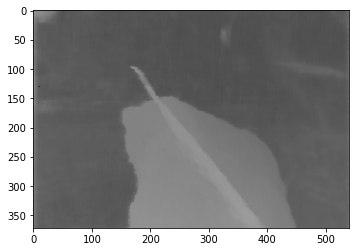

(Pdb) img_disp(d_BV)
*** NameError: name 'd_BV' is not defined
(Pdb) img_disp(d_BH_
*** SyntaxError: unexpected EOF while parsing
(Pdb) img_disp(d_BH)


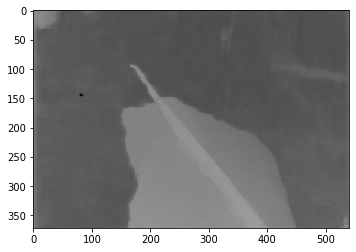

(Pdb) img_disp(d_FD)


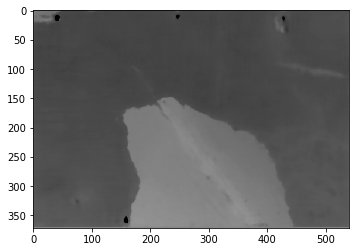

(Pdb) img_disp(d_RV)


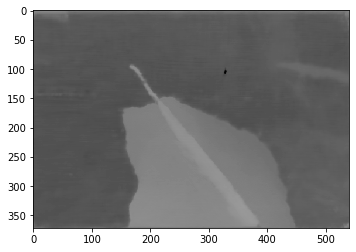

(Pdb) q


BdbQuit: 

In [9]:
Y,T = single_run([3,3], img_name = 'Rock.png')


In [15]:
plt.imshow(get_numpy(Y-T))

tensor(-1.)

C:\Users\mummu\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


> c:\users\mummu\documents\github\view-synthesis\custom\network.py(336)forward()
-> return I, M
(Pdb) img_disp(d_BD)


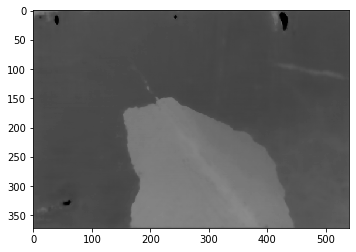

(Pdb) img_disp(FD)
*** NameError: name 'FD' is not defined
(Pdb) img_disp(d_FD)


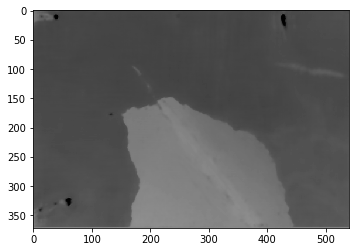

(Pdb) n
--Return--
> c:\users\mummu\documents\github\view-synthesis\custom\network.py(336)forward()->(tensor([[[[ 0...vice='cuda:0'), tensor([[[[[3...vice='cuda:0'))
-> return I, M
(Pdb) img_disp(d_TH)


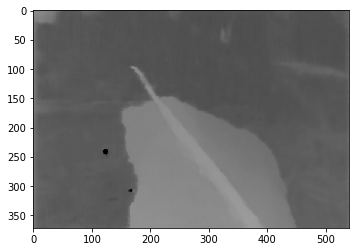

(Pdb) q


BdbQuit: 

In [9]:
Y = single_run([3,3], img_name = 'Rock.png')
plt.imshow(get_numpy(d[0,0]+4)/8, cmap = 'gray', vmin = 0, vmax = 1.0);

In [8]:
# Run for all examples in the folder and every perspectives
def run_all_examples(img_path):
        
    files = [file for file in os.listdir(img_path) if file.endswith(".png")]
    ps = np.ndarray((len(files),7,7))

    for fi in range(len(files)):

        file = files[fi]

        print("Current file {}: {}" .format(fi,file))

        img = cv2.imread(os.path.join(img_path, file))
        img = processLF(trans(img), lfsize, gamma_val)

        corn = img[:, :, [0, -1, 0, -1], [0, 0, -1, -1], :].squeeze()

        for i in range(7):
            for j in range(7):

                T = get_numpy(img[:, :, i, j, :])
                Y = synthesizeView(corn, [i, j])
                Y = get_numpy(Y)

                ps[fi,i,j] = psnr_1(T, Y)
        
        psnr_excl_corners = ps[fi].reshape(-1)[[i for i in range(49) if (i-np.array((0,6,42,48))).all()]].mean()
        
        print("Current PSNR: {}" .format(psnr_excl_corners))
    
    return ps
                
    

In [9]:
ps = run_all_examples(img_paper)

Current file 0: Cars.png


C:\Users\mummu\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Current PSNR: 34.76030149155272
Current file 1: Flower1.png
Current PSNR: 33.105504027784434
Current file 2: Flower2.png
Current PSNR: 33.638000461474014
Current file 3: Rock.png
Current PSNR: 35.84843818604451
Current file 4: Seahorse.png
Current PSNR: 33.928579501128326


In [10]:
ps = run_all_examples(img_paper)

Current file 0: Cars.png


C:\Users\mummu\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Current PSNR: 34.29343661018799
Current file 1: Flower1.png
Current PSNR: 32.61797985603709
Current file 2: Flower2.png
Current PSNR: 33.37610971137828
Current file 3: Rock.png
Current PSNR: 35.36902675965966
Current file 4: Seahorse.png
Current PSNR: 33.471256793255435


In [12]:
np.set_printoptions(precision = 2)
ps[3]

array([[37.91, 36.19, 35.81, 35.89, 35.93, 36.21, 38.51],
       [36.13, 35.52, 35.24, 35.32, 35.39, 35.63, 36.57],
       [35.44, 35.01, 34.84, 34.93, 35.1 , 35.31, 35.93],
       [35.2 , 34.78, 34.61, 34.76, 35.  , 35.2 , 35.76],
       [35.43, 34.96, 34.74, 34.86, 35.13, 35.37, 36.06],
       [36.22, 35.5 , 35.1 , 35.13, 35.32, 35.56, 36.66],
       [37.79, 35.95, 35.44, 35.43, 35.53, 35.84, 38.  ]])

In [ ]:
# np.set_printoptions(precision=2)
# print(ps)

#for index, val in enumerate(list)
files = [file for file in os.listdir(img_dir) if file.endswith(".png")]

In [ ]:
#for _, fi in enumerate(files):
ps.reshape(len(files),-1)[:,[i for i in range(49) if (i-np.array((0,6,42,48))).all()]].mean()